In [110]:
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random as rnd
#Para BFS
from collections import deque
import Set

ModuleNotFoundError: No module named 'Set'

<h1>Módulo 4: Redes<h4>

<h3>1. Creación del Grafo</h3>
<blockquote>Lo primero que hacemos es levantar el archivo data.csv para identificar los nombres del autor y coautur/es.</blockquote>

In [2]:
path_to_data = "data.csv"
data = open(path_to_data,'r')
all_lines = data.readlines()
data.close()

In [3]:
all_lines[0]

'1992, B368,  Nucl.Phys., Horne & Horowitz,  Exact Black String Solutions in Three Dimensions\n'

<blockquote><b>Obs:</b> El formato parace ser: 
<br>"Fecha, unCodigo, unlugar, varios Autores/Coautores, unNombreDePublicacion"
<br>Sólo nos interesan los autores/coautores.</blockquote>

In [21]:
G = nx.Graph()

def strip_withou_space(aString):
    return str.strip(aString).replace(" ", "")

## Every authour/coauthor is a node.
##This is a way to map from names to numbers that represent the index of the node in our graph.
name_to_node_index = {}

## Every co-authorship is an edges of our graph.
edges = set()

for a_pub_info in all_lines:    
    pub_split = a_pub_info.split(",")[3]
    list_of_authors = pub_split.split("&")
    names_in_this_pub = list( map(strip_withou_space, list_of_authors) )
    
    for name in names_in_this_pub:
        if name not in name_to_node_index:
            name_to_node_index[name] = len(name_to_node_index)+1
    
    nodes_to_connect = [name_to_node_index[name] for name in names_in_this_pub]
    K = nx.complete_graph(nodes_to_connect)
    G.add_edges_from(K.edges)
    G.add_nodes_from(K) # if there is only one author, you add K1. K1 has no edge.

In [22]:
print ( "Cantidad de nodos en el grafo: {}".format(G.number_of_nodes()) )
print ( "Cantidad de ejes en el grafo: {}".format(G.number_of_edges()) )

Cantidad de nodos en el grafo: 4027
Cantidad de ejes en el grafo: 7977


<h3>Primer vista del grafo</h3>
<blockquote>Hechemos un vistazo del lag que tiene para dibujar esto</blockquote>

In [23]:
plt.clf()
limits = plt.axis('off')
nx.draw_networkx(G, pos=nx.spring_layout(G), node_shape="o", node_size=100, with_labels=False, node_color='orange grey', edge_color='black')
plt.show()

KeyboardInterrupt: 

<h3>2. Distribución de Grado</h3>
<blockquote>Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica y log-log. Argument, a partir de los gráficos, de qu ́e tipo de distribución se trata.</blockquote>

In [24]:
list_of_degres = nx.degree_histogram(G)
x = pd.Series(list_of_degres, name="Distribucion de los Grados")

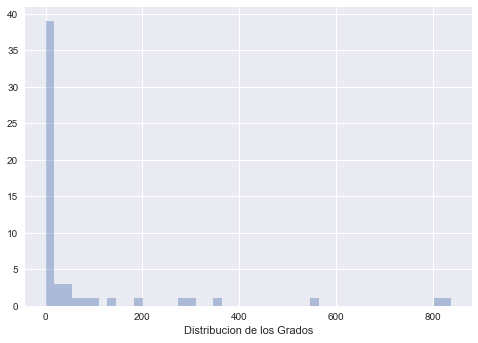

In [25]:
#No se hacer histogramas con la altura == a los valores de X
plt.clf()
ax1 = sns.distplot(x, hist=True, kde=False, rug=False)
sns.plt.show()

Lo bueno sería dibujar cada una con la exponencial al lado, pero no pude generar los valores de la exponencial. De todas formas tampoco me quedó claro cuando la comparación tiene sentido. El mártes lo pregunto.

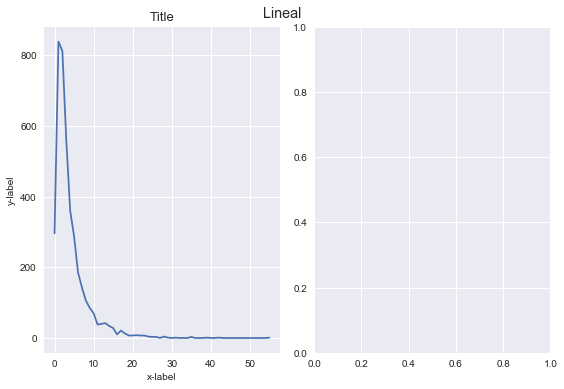

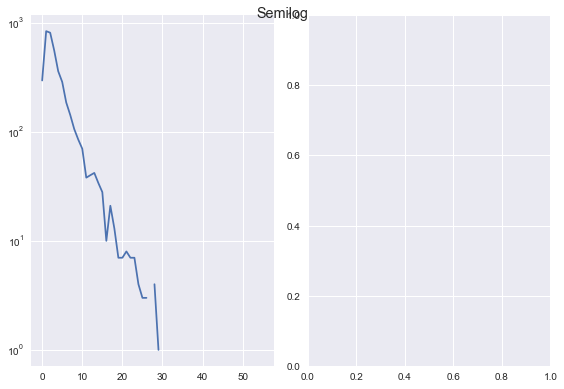

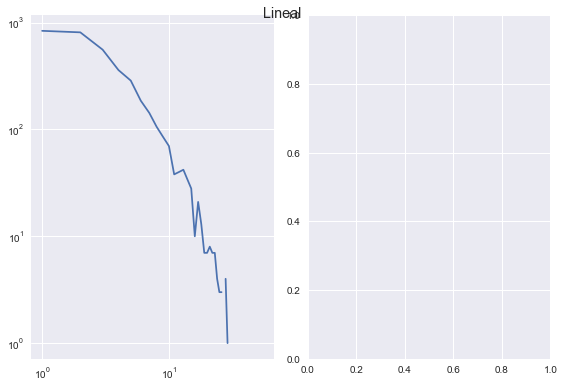

In [28]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)

#ax1.suptitle("Lineal")
ax1.plot(x)
ax1.set_xlabel('x-label', fontsize=10)
ax1.set_ylabel('y-label', fontsize=10)
ax1.set_title('Title', fontsize=13)

plt.suptitle("Lineal")
plt.tight_layout()
plt.show()

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
ax1.semilogy(x)
#ax3.suptitle("Semilogy")
#plt.plot(x)
plt.suptitle("Semilog")
plt.tight_layout()
plt.show()

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
ax1.loglog(x)
#ax5.suptitle("loglog")
#plt.plot(x)
#plt.show()
plt.suptitle("Lineal")
plt.tight_layout()
plt.show()

##Deberíamos graficarlos al lado de lo mismo que la exponencial en este rango de valores y compararlos

#plt.plot(x)
#plt.ylabel('some numbers')
#plt.loglog()
#plt.show()

<h3>3. Componentes Conexas</h3>
<blockquote>Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.</blockquote>

In [29]:
print( "Es grafo es conexo." if nx.is_connected(G) else "El grafo no es conexo." )
print( "La cantidad de compontes conexas es {}.".format(nx.number_connected_components(G)) )

giant_component = max(nx.connected_component_subgraphs(G), key=len)
print( "La componente gigante tiene {} nodos.".format(giant_component.number_of_nodes()) )

El grafo no es conexo.
La cantidad de compontes conexas es 532.
La componente gigante tiene 3048 nodos.


<h3>4. Tamaños de Vecindades</h3>
<blockquote>Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación.</blockquote>

<b>Dudas:</b> 
<ul>
    <li>No me queda claro si el número de autores alcanzados en función de la distancia te diría la 
    |\sum {\forall v \in Vecino(semilla)} Vecinos(v)|
    o
    |\sum {\forall v \in Vecino(semilla)} Vecinos(v)| / |Vecinos(semilla)|</li>
</ul>

In [145]:
## Common BFS counting at each depth:
#####"how many nodes are at the next depth of the bfs tree?" (this are the nodes that we havent visited yet)
#####"using the nodes at the actual depth, how many nodes can we visit?"

n_repeat = 100
nodes_seeds = [ rnd.choice(np.array(giant_component.nodes)) for _ in range(n_repeat) ]
results_authors_that_can_be_visited_in_func_of_depth = []
results_new_nodes_in_func_of_depth = []

for a_node in nodes_seeds:    
    a_bfs_tree = nx.bfs_tree(giant_component, a_node)
    tree_length = len(nx.dag_longest_path(a_bfs_tree))
    
    visited_sets = np.array([set() for _ in range(tree_length)])
    authors_that_can_be_visited_in_func_of_depth = np.zeros((tree_length))
    new_nodes_in_func_of_depth = np.zeros((tree_length))

    d = deque([(0,a_node)])
    while len(d) != 0:
        (depth,node) = d.pop()
        #Nodes in next step weren't visited 
        node_neighbors = list(nx.neighbors(a_bfs_tree, node))
        new_nodes_in_func_of_depth[depth] += len(node_neighbors)
        #This is actually how many nodes are neighbors of another node at this depth of bfs tree 
        visited_sets[depth].update(list(nx.neighbors(giant_component, node)))
        authors_that_can_be_visited_in_func_of_depth[depth] = len(visited_sets[depth])
        #Next step
        for ng in node_neighbors:
            d.append((depth+1,ng))
    results_authors_that_can_be_visited_in_func_of_depth.append(list(map(int, authors_that_can_be_visited_in_func_of_depth)))
    results_new_nodes_in_func_of_depth.append(list(map(int, new_nodes_in_func_of_depth)))

In [146]:
size_max = len(max( [max(results_authors_that_can_be_visited_in_func_of_depth,key=len),
      max(results_new_nodes_in_func_of_depth,key=len)]
   ))

for index, an_array in  enumerate(results_authors_that_can_be_visited_in_func_of_depth):
    results_authors_that_can_be_visited_in_func_of_depth[index] = np.pad(an_array,(0,size_max-len(an_array)),'constant')
        
for index, an_array in  enumerate(results_new_nodes_in_func_of_depth):
    results_new_nodes_in_func_of_depth[index] = np.pad(an_array,(0,size_max-len(an_array)),'constant')

In [140]:
#Ahora deberíamos hacer el promedio en cada posición supongo pero si hay un cero no nos interesa creo. No estoy seguro de eso.

array([4, 4, 4, 4, 4, 0, 0, 0])

In [159]:
results_new_nodes_in_func_of_depth

array([[  1,   8,  27, ...,   0,   0,   0],
       [  9,  68, 306, ...,   0,   0,   0],
       [  2,   6,  38, ...,   0,   0,   0],
       ..., 
       [  2,  27,  97, ...,   0,   0,   0],
       [  7,  44, 275, ...,   0,   0,   0],
       [  4,  22, 130, ...,   0,   0,   0]])